# Assignment No. 4


## Submitters
- **Name:** Ofir Vaknin - **ID:** 323920769  
- **Name:** Ohad Shapurkar - **ID:** 211768767


Imports:

In [3]:
# Standard library
import random
from pathlib import Path
import tarfile
import io
import contextlib
import os

# Numerical computation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image handling
from PIL import Image

# Data loading
from scipy.io import loadmat

# PyTorch and vision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Dependencies handling
import urllib3
from packaging.version import Version

# Utilities
from tqdm import tqdm
import logging


In [4]:
import importlib.util

if importlib.util.find_spec("ultralytics") is None:
    !pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.7 MB/s eta 0:00:00


Data Loading (Oxford 102 Flowers):

/tmp/ipython-input-2846046474.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_DIR)


Number of images: 8189
Number of classes: 102


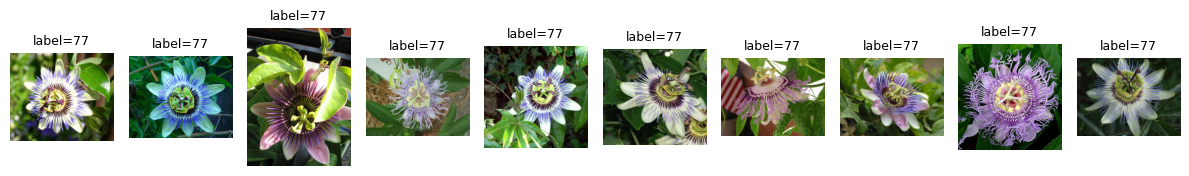

In [5]:
ROOT = Path("/content")
DATA_DIR = ROOT / "data" / "oxford102"
IMAGES_DIR = DATA_DIR / "jpg"
DATA_DIR.mkdir(parents=True, exist_ok=True)

FLOWERS_TGZ = DATA_DIR / "102flowers.tgz"
LABELS_MAT  = DATA_DIR / "imagelabels.mat"

# Download required files (images + labels)
if not FLOWERS_TGZ.exists():
    !wget -q -O "{FLOWERS_TGZ}" "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"

if not LABELS_MAT.exists():
    !wget -q -O "{LABELS_MAT}" "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# Extract images if needed
if not IMAGES_DIR.exists() or len(list(IMAGES_DIR.glob("*.jpg"))) == 0:
    with tarfile.open(FLOWERS_TGZ, "r:gz") as tar:
        tar.extractall(path=DATA_DIR)

# Load labels (1..102)
labels = loadmat(LABELS_MAT)["labels"].squeeze().astype(int)

# Collect image paths
image_paths = sorted(IMAGES_DIR.glob("image_*.jpg"))
assert len(image_paths) == len(labels), "Mismatch between images and labels"

print("Number of images:", len(image_paths))
print("Number of classes:", len(np.unique(labels)))

# Show 10 sample images
fig, axes = plt.subplots(1, 10, figsize=(12, 3))

for ax, idx in zip(axes, range(10)):
    img = Image.open(image_paths[idx]).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"label={labels[idx]}", fontsize=9)

plt.tight_layout()
plt.show()



Random split (50% train / 25% val / 25% test) — repeated twice:

In [6]:
SEED_SPLIT_1 = 123
SEED_SPLIT_2 = 456

def make_random_split(labels_array: np.ndarray, seed: int):

   # Returns a dict of index arrays: {'train_idx', 'val_idx', 'test_idx'}.

    rng = np.random.default_rng(seed)
    n = len(labels_array)

    all_idx = np.arange(n)
    rng.shuffle(all_idx)

    n_train = n // 2
    n_val = n // 4
    n_test = n - n_train - n_val

    train_idx = all_idx[:n_train]
    val_idx   = all_idx[n_train:n_train + n_val]
    test_idx  = all_idx[n_train + n_val:]

    assert len(train_idx) == n_train
    assert len(val_idx) == n_val
    assert len(test_idx) == n_test
    assert len(set(train_idx) & set(val_idx)) == 0
    assert len(set(train_idx) & set(test_idx)) == 0
    assert len(set(val_idx) & set(test_idx)) == 0

    return {
        "seed": seed,
        "train_idx": train_idx,
        "val_idx": val_idx,
        "test_idx": test_idx,
    }

def split_summary(name: str, split: dict, labels_array: np.ndarray):
    def counts(idxs):
        y = labels_array[idxs]
        return len(idxs), len(np.unique(y))

    n_tr, c_tr = counts(split["train_idx"])
    n_va, c_va = counts(split["val_idx"])
    n_te, c_te = counts(split["test_idx"])

    print(f"{name} (seed={split['seed']}):")
    print(f"  Train: {n_tr} samples | {c_tr} unique classes")
    print(f"  Val:   {n_va} samples | {c_va} unique classes")
    print(f"  Test:  {n_te} samples | {c_te} unique classes")

SPLIT1 = make_random_split(labels, SEED_SPLIT_1)
SPLIT2 = make_random_split(labels, SEED_SPLIT_2)

split_summary("SPLIT1", SPLIT1, labels)
split_summary("SPLIT2", SPLIT2, labels)


SPLIT1 (seed=123):
  Train: 4094 samples | 102 unique classes
  Val:   2047 samples | 102 unique classes
  Test:  2048 samples | 102 unique classes
SPLIT2 (seed=456):
  Train: 4094 samples | 102 unique classes
  Val:   2047 samples | 102 unique classes
  Test:  2048 samples | 102 unique classes


## Preprocessing and Dataset Construction

The following preprocessing steps were applied to the raw images before feeding them into the network:

- **Resizing**: Images were resized to a fixed resolution of 224×224 pixels to ensure uniform input dimensions compatible with the VGG19 architecture.

- **Normalization**: Pixel values were normalized using the ImageNet mean and standard deviation to match the statistical properties expected by pretrained models.

- **Data Augmentation (Training set only)**: Random horizontal flipping and small random rotations were applied to the training images in order to improve generalization.

- **Deterministic preprocessing (Validation and Test sets)**: Validation and test images were preprocessed using resizing and normalization only, without applying any data augmentation.

- **Label encoding**: Class labels were converted from the original range of 1–102 to 0–101 to support multi-class classification in PyTorch.

- **Dataset construction**: A custom dataset class was implemented to return `(image, label)` pairs according to the selected data split.


In [7]:
IMG_SIZE_VGG = 224  # Input resolution (required by VGG19)

# ImageNet normalization statistics (pretrained VGG19)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# -------------------------
# Resizing + Normalization + Data Augmentation (Training set)
# -------------------------
TRANSFORM_TRAIN_VGG = transforms.Compose([
    transforms.Resize((IMG_SIZE_VGG, IMG_SIZE_VGG)),   # Resizing
    transforms.RandomHorizontalFlip(p=0.5),            # Data augmentation
    transforms.RandomRotation(degrees=15),             # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Normalization
])

# -------------------------
# Resizing + Normalization (Validation and Test sets)
# -------------------------
TRANSFORM_EVAL_VGG = transforms.Compose([
    transforms.Resize((IMG_SIZE_VGG, IMG_SIZE_VGG)),   # Resizing
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Normalization
])

# -------------------------
# Dataset construction
# -------------------------
class Oxford102Dataset(Dataset):

   # Returns (image, label) pairs with labels mapped from 1–102 to 0–101

    def __init__(self, image_paths, labels, indices, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.indices = np.array(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = int(self.indices[i])
        img = Image.open(self.image_paths[idx]).convert("RGB")
        y = int(self.labels[idx]) - 1  # Label encoding: 1–102 → 0–101

        if self.transform is not None:
            img = self.transform(img)

        return img, y

# -------------------------
# DATASET BUILD (Split 1 + Split 2)
# -------------------------
def build_datasets_for_split(split, transform_train, transform_eval):
    ds_train = Oxford102Dataset(image_paths, labels, split["train_idx"], transform=transform_train)
    ds_val   = Oxford102Dataset(image_paths, labels, split["val_idx"],   transform=transform_eval)
    ds_test  = Oxford102Dataset(image_paths, labels, split["test_idx"],  transform=transform_eval)
    return ds_train, ds_val, ds_test

DS_TRAIN_SPLIT1, DS_VAL_SPLIT1, DS_TEST_SPLIT1 = build_datasets_for_split(
    SPLIT1, TRANSFORM_TRAIN_VGG, TRANSFORM_EVAL_VGG
)

DS_TRAIN_SPLIT2, DS_VAL_SPLIT2, DS_TEST_SPLIT2 = build_datasets_for_split(
    SPLIT2, TRANSFORM_TRAIN_VGG, TRANSFORM_EVAL_VGG
)

print("Dataset sizes:")
print("SPLIT1 ->", len(DS_TRAIN_SPLIT1), len(DS_VAL_SPLIT1), len(DS_TEST_SPLIT1))
print("SPLIT2 ->", len(DS_TRAIN_SPLIT2), len(DS_VAL_SPLIT2), len(DS_TEST_SPLIT2))


Dataset sizes:
SPLIT1 -> 4094 2047 2048
SPLIT2 -> 4094 2047 2048


## DataLoader and Training Configuration

The datasets were wrapped using PyTorch DataLoaders to enable mini-batch training.  
Shuffling was applied only to the training set, while validation and test sets were iterated deterministically.  
The same batch size and loading configuration were used across all experiments to ensure a fair comparison.


In [8]:
# -------------------------
# DataLoader configuration
# -------------------------

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = (DEVICE.type == "cuda")
PIN_MEMORY = USE_CUDA

BATCH_SIZE = 32
NUM_WORKERS = 2

def build_dataloaders(ds_train, ds_val, ds_test, batch_size):
    dl_train = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    dl_test = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    return dl_train, dl_val, dl_test


DL_TRAIN_SPLIT1, DL_VAL_SPLIT1, DL_TEST_SPLIT1 = build_dataloaders(
    DS_TRAIN_SPLIT1, DS_VAL_SPLIT1, DS_TEST_SPLIT1, BATCH_SIZE
)

DL_TRAIN_SPLIT2, DL_VAL_SPLIT2, DL_TEST_SPLIT2 = build_dataloaders(
    DS_TRAIN_SPLIT2, DS_VAL_SPLIT2, DS_TEST_SPLIT2, BATCH_SIZE
)

print("SPLIT1 batches (train / val / test):",
      len(DL_TRAIN_SPLIT1), len(DL_VAL_SPLIT1), len(DL_TEST_SPLIT1))
print("SPLIT2 batches (train / val / test):",
      len(DL_TRAIN_SPLIT2), len(DL_VAL_SPLIT2), len(DL_TEST_SPLIT2))


SPLIT1 batches (train / val / test): 128 64 64
SPLIT2 batches (train / val / test): 128 64 64


## VGG19

A VGG19 network pretrained on ImageNet was used as the base model.  
The convolutional backbone was initialized with pretrained weights, while a new classification head was added to adapt the network to the 102 flower categories.


In [9]:
# -------------------------
# VGG19 model (Transfer Learning)
# -------------------------

NUM_CLASSES = 102

def build_vgg19_model(num_classes):
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

    # Freeze convolutional backbone
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier head
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

    return model

MODEL_VGG19 = build_vgg19_model(NUM_CLASSES).to(DEVICE)


# Number of trainable parameter tensors relative to the pretrained model
trainable_params = sum(p.requires_grad for p in MODEL_VGG19.parameters())
total_params = sum(1 for _ in MODEL_VGG19.parameters())

print(f"Trainable parameters: {trainable_params} / {total_params}")


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 72.7MB/s]


Trainable parameters: 6 / 38


## VGG19 Training Setup

The model was trained using cross-entropy loss for multi-class classific.


In [10]:
EPOCHS_VGG = 10
LR_VGG = 1e-3

CRITERION_CE = nn.CrossEntropyLoss()

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for x, y in dataloader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (torch.argmax(logits, dim=1) == y).sum().item()
        total_n += x.size(0)

    return {
        "loss": total_loss / total_n,
        "acc": total_correct / total_n
    }

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for x, y in tqdm(dataloader, desc="Train", leave=False, disable=True):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (torch.argmax(logits, dim=1) == y).sum().item()
        total_n += x.size(0)

    return {
        "loss": total_loss / total_n,
        "acc": total_correct / total_n
    }

def train_model_vgg19(model, dl_train, dl_val, dl_test, epochs, lr, device):
    optimizer = torch.optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=lr
    )

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [],   "val_acc": [],
        "test_loss": [],  "test_acc": []
    }

    for epoch in range(1, epochs + 1):
        train_metrics = train_epoch(model, dl_train, CRITERION_CE, optimizer, device)
        val_metrics   = evaluate_epoch(model, dl_val,  CRITERION_CE, device)
        test_metrics  = evaluate_epoch(model, dl_test, CRITERION_CE, device)  # for analysis (section 9)

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["test_loss"].append(test_metrics["loss"])
        history["test_acc"].append(test_metrics["acc"])

        print(
            f"Epoch {epoch:02d}/{epochs} | "
            f"train: acc={train_metrics['acc']:.3f}, loss={train_metrics['loss']:.3f} | "
            f"val: acc={val_metrics['acc']:.3f}, loss={val_metrics['loss']:.3f} | "
            f"test: acc={test_metrics['acc']:.3f}, loss={test_metrics['loss']:.3f}"
        )

    return history


## VGG19 Training (Split 1 and Split 2)

The same training procedure was executed for two different random splits to assess stability.  
Test metrics are reported per epoch for analysis only (not used for hyperparameter selection).


In [11]:
print("\n===== VGG19 TRAINING – SPLIT 1 =====\n")

# SPLIT1
MODEL_VGG19_SPLIT1 = build_vgg19_model(NUM_CLASSES).to(DEVICE)
HIST_VGG19_SPLIT1 = train_model_vgg19(
    MODEL_VGG19_SPLIT1,
    DL_TRAIN_SPLIT1, DL_VAL_SPLIT1, DL_TEST_SPLIT1,
    epochs=EPOCHS_VGG, lr=LR_VGG, device=DEVICE
)

print("\n\n===== VGG19 TRAINING – SPLIT 2 =====\n")

# SPLIT2
MODEL_VGG19_SPLIT2 = build_vgg19_model(NUM_CLASSES).to(DEVICE)
HIST_VGG19_SPLIT2 = train_model_vgg19(
    MODEL_VGG19_SPLIT2,
    DL_TRAIN_SPLIT2, DL_VAL_SPLIT2, DL_TEST_SPLIT2,
    epochs=EPOCHS_VGG, lr=LR_VGG, device=DEVICE
)



===== VGG19 TRAINING – SPLIT 1 =====

Epoch 01/10 | train: acc=0.142, loss=4.026 | val: acc=0.407, loss=2.556 | test: acc=0.380, loss=2.648
Epoch 02/10 | train: acc=0.344, loss=2.824 | val: acc=0.540, loss=1.784 | test: acc=0.528, loss=1.875
Epoch 03/10 | train: acc=0.440, loss=2.441 | val: acc=0.651, loss=1.429 | test: acc=0.632, loss=1.473
Epoch 04/10 | train: acc=0.491, loss=2.294 | val: acc=0.658, loss=1.405 | test: acc=0.633, loss=1.497
Epoch 05/10 | train: acc=0.526, loss=2.109 | val: acc=0.693, loss=1.195 | test: acc=0.699, loss=1.185
Epoch 06/10 | train: acc=0.559, loss=2.028 | val: acc=0.711, loss=1.306 | test: acc=0.692, loss=1.236
Epoch 07/10 | train: acc=0.597, loss=1.854 | val: acc=0.714, loss=1.173 | test: acc=0.708, loss=1.138
Epoch 08/10 | train: acc=0.617, loss=1.797 | val: acc=0.749, loss=1.026 | test: acc=0.744, loss=1.025
Epoch 09/10 | train: acc=0.616, loss=1.862 | val: acc=0.742, loss=1.051 | test: acc=0.732, loss=1.055
Epoch 10/10 | train: acc=0.642, loss=1.704 

## YOLOv5

A YOLOv5 model pretrained on COCO was used as the second base model.  
We applied Transfer Learning by freezing the pretrained backbone and training a new classification head to output 102 flower classes.


In [12]:
# Silence YOLOv5 hub prints
os.environ["YOLOv5_VERBOSE"] = "False"
os.environ["ULTRALYTICS_VERBOSE"] = "False"


## YOLOv5 Fine-Tuning

To improve accuracy, we fine-tune a small part of the YOLOv5 backbone.  
We keep most layers frozen and unfreeze only the last blocks using a smaller learning rate.


In [13]:
def unfreeze_last_yolo_layers(model_yolo, n_last=30):
    layers = list(model_yolo.backbone.det.model.model)
    for layer in layers[-n_last:]:
        for p in layer.parameters():
            p.requires_grad = True


## YOLOv5 Preprocessing

Images were resized to 224×224 and normalized using ImageNet statistics.  
The training set also used light augmentation (horizontal flip and rotation), while validation and test used deterministic preprocessing only.

In [14]:
# -------------------------
# YOLOv5 preprocessing
# -------------------------
IMG_SIZE_YOLO = 224

TRANSFORM_TRAIN_YOLO = transforms.Compose([
    transforms.Resize((IMG_SIZE_YOLO, IMG_SIZE_YOLO)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

TRANSFORM_EVAL_YOLO = transforms.Compose([
    transforms.Resize((IMG_SIZE_YOLO, IMG_SIZE_YOLO)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [15]:
# -------------------------
# YOLOv5 model (Transfer Learning)
# -------------------------
class YOLOv5Backbone(nn.Module):
    def __init__(self, yolo_variant="yolov5s", pretrained=True, freeze=True):
        super().__init__()

        with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
            hub_model = torch.hub.load("ultralytics/yolov5", yolo_variant, pretrained=pretrained)

            import sys
            if "utils.general" in sys.modules and hasattr(sys.modules["utils.general"], "LOGGER"):
                sys.modules["utils.general"].LOGGER.setLevel(50)

        self.det = hub_model.model  # Pretrained YOLOv5 backbone

        if freeze:
            for p in self.det.parameters():
                p.requires_grad = False

        self._feat = None

        def _hook(_, __, output):
            self._feat = output

        stack = self.det.model.model
        stack[-2].register_forward_hook(_hook)

    def forward(self, x):
        self._feat = None
        _ = self.det(x)
        return self._feat


class YOLOv5Classifier(nn.Module):
    def __init__(self, num_classes=102, yolo_variant="yolov5s", pretrained=True, freeze_backbone=True):
        super().__init__()
        self.backbone = YOLOv5Backbone(yolo_variant=yolo_variant, pretrained=pretrained, freeze=freeze_backbone)
        self.classifier = None
        self.num_classes = num_classes

    def init_head(self, img_size, device):
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size, device=device)
            feat = self.backbone(dummy)
            if feat is None:
                raise RuntimeError("Backbone feature extraction failed (hook returned None).")
            feat_dim = feat.mean(dim=(2, 3)).shape[1]

        self.classifier = nn.Linear(feat_dim, self.num_classes).to(device)

    def forward(self, x):
        feat = self.backbone(x)
        pooled = feat.mean(dim=(2, 3))
        logits = self.classifier(pooled)
        return logits


MODEL_YOLO = YOLOv5Classifier(
    num_classes=NUM_CLASSES,
    yolo_variant="yolov5s",
    pretrained=True,
    freeze_backbone=True
).to(DEVICE)

MODEL_YOLO.init_head(IMG_SIZE_YOLO, DEVICE)

# Number of trainable parameter tensors relative to the pretrained model
trainable_params = sum(p.requires_grad for p in MODEL_YOLO.parameters())
total_params = sum(1 for _ in MODEL_YOLO.parameters())
print(f"Trainable parameter tensors: {trainable_params} / {total_params}")


Trainable parameter tensors: 2 / 122


## YOLOv5 Training Setup


In [16]:
# -------------------------
# YOLOv5 fine-tuning configuration
# -------------------------
EPOCHS_YOLO_STAGE1 = 2
LR_YOLO_STAGE1 = 1e-3

EPOCHS_YOLO_STAGE2 = 8
LR_YOLO_STAGE2 = 1e-4

YOLO_UNFREEZE_LAST = 30

# -------------------------
# YOLOv5 datasets + dataloaders (Split 1 + Split 2)
# -------------------------
DS_TRAIN_YOLO_SPLIT1, DS_VAL_YOLO_SPLIT1, DS_TEST_YOLO_SPLIT1 = build_datasets_for_split(
    SPLIT1, TRANSFORM_TRAIN_YOLO, TRANSFORM_EVAL_YOLO
)
DS_TRAIN_YOLO_SPLIT2, DS_VAL_YOLO_SPLIT2, DS_TEST_YOLO_SPLIT2 = build_datasets_for_split(
    SPLIT2, TRANSFORM_TRAIN_YOLO, TRANSFORM_EVAL_YOLO
)

DL_TRAIN_YOLO_SPLIT1, DL_VAL_YOLO_SPLIT1, DL_TEST_YOLO_SPLIT1 = build_dataloaders(
    DS_TRAIN_YOLO_SPLIT1, DS_VAL_YOLO_SPLIT1, DS_TEST_YOLO_SPLIT1, BATCH_SIZE
)
DL_TRAIN_YOLO_SPLIT2, DL_VAL_YOLO_SPLIT2, DL_TEST_YOLO_SPLIT2 = build_dataloaders(
    DS_TRAIN_YOLO_SPLIT2, DS_VAL_YOLO_SPLIT2, DS_TEST_YOLO_SPLIT2, BATCH_SIZE
)

print("YOLOv5 SPLIT1 batches (train / val / test):",
      len(DL_TRAIN_YOLO_SPLIT1), len(DL_VAL_YOLO_SPLIT1), len(DL_TEST_YOLO_SPLIT1))

print("YOLOv5 SPLIT2 batches (train / val / test):",
      len(DL_TRAIN_YOLO_SPLIT2), len(DL_VAL_YOLO_SPLIT2), len(DL_TEST_YOLO_SPLIT2))


YOLOv5 SPLIT1 batches (train / val / test): 128 64 64
YOLOv5 SPLIT2 batches (train / val / test): 128 64 64


## YOLOv5 Training (Split 1 and Split 2)

The same training procedure was executed for two different random splits to assess stability.  
Test metrics are reported per epoch for analysis only (not used for hyperparameter selection).


In [17]:
print("\n===== YOLOv5 TRAINING – SPLIT 1 =====\n")

MODEL_YOLO_SPLIT1 = YOLOv5Classifier(
    num_classes=NUM_CLASSES,
    yolo_variant="yolov5s",
    pretrained=True,
    freeze_backbone=True
).to(DEVICE)
MODEL_YOLO_SPLIT1.init_head(IMG_SIZE_YOLO, DEVICE)

# Stage 1: head only
HIST_YOLO_SPLIT1_STAGE1 = train_model_vgg19(
    MODEL_YOLO_SPLIT1,
    DL_TRAIN_YOLO_SPLIT1, DL_VAL_YOLO_SPLIT1, DL_TEST_YOLO_SPLIT1,
    epochs=EPOCHS_YOLO_STAGE1, lr=LR_YOLO_STAGE1, device=DEVICE
)

# Stage 2: fine-tune last backbone blocks
unfreeze_last_yolo_layers(MODEL_YOLO_SPLIT1, n_last=YOLO_UNFREEZE_LAST)

HIST_YOLO_SPLIT1_STAGE2 = train_model_vgg19(
    MODEL_YOLO_SPLIT1,
    DL_TRAIN_YOLO_SPLIT1, DL_VAL_YOLO_SPLIT1, DL_TEST_YOLO_SPLIT1,
    epochs=EPOCHS_YOLO_STAGE2, lr=LR_YOLO_STAGE2, device=DEVICE
)

# Merge histories for plotting
HIST_YOLO_SPLIT1 = {
    "train_loss": HIST_YOLO_SPLIT1_STAGE1["train_loss"] + HIST_YOLO_SPLIT1_STAGE2["train_loss"],
    "train_acc":  HIST_YOLO_SPLIT1_STAGE1["train_acc"]  + HIST_YOLO_SPLIT1_STAGE2["train_acc"],
    "val_loss":   HIST_YOLO_SPLIT1_STAGE1["val_loss"]   + HIST_YOLO_SPLIT1_STAGE2["val_loss"],
    "val_acc":    HIST_YOLO_SPLIT1_STAGE1["val_acc"]    + HIST_YOLO_SPLIT1_STAGE2["val_acc"],
    "test_loss":  HIST_YOLO_SPLIT1_STAGE1["test_loss"]  + HIST_YOLO_SPLIT1_STAGE2["test_loss"],
    "test_acc":   HIST_YOLO_SPLIT1_STAGE1["test_acc"]   + HIST_YOLO_SPLIT1_STAGE2["test_acc"],
}

print("\n===== YOLOv5 TRAINING – SPLIT 2 =====\n")

MODEL_YOLO_SPLIT2 = YOLOv5Classifier(
    num_classes=NUM_CLASSES,
    yolo_variant="yolov5s",
    pretrained=True,
    freeze_backbone=True
).to(DEVICE)
MODEL_YOLO_SPLIT2.init_head(IMG_SIZE_YOLO, DEVICE)

# Stage 1: head only
HIST_YOLO_SPLIT2_STAGE1 = train_model_vgg19(
    MODEL_YOLO_SPLIT2,
    DL_TRAIN_YOLO_SPLIT2, DL_VAL_YOLO_SPLIT2, DL_TEST_YOLO_SPLIT2,
    epochs=EPOCHS_YOLO_STAGE1, lr=LR_YOLO_STAGE1, device=DEVICE
)

# Stage 2: fine-tune last backbone blocks
unfreeze_last_yolo_layers(MODEL_YOLO_SPLIT2, n_last=YOLO_UNFREEZE_LAST)

HIST_YOLO_SPLIT2_STAGE2 = train_model_vgg19(
    MODEL_YOLO_SPLIT2,
    DL_TRAIN_YOLO_SPLIT2, DL_VAL_YOLO_SPLIT2, DL_TEST_YOLO_SPLIT2,
    epochs=EPOCHS_YOLO_STAGE2, lr=LR_YOLO_STAGE2, device=DEVICE
)

# Merge histories for plotting
HIST_YOLO_SPLIT2 = {
    "train_loss": HIST_YOLO_SPLIT2_STAGE1["train_loss"] + HIST_YOLO_SPLIT2_STAGE2["train_loss"],
    "train_acc":  HIST_YOLO_SPLIT2_STAGE1["train_acc"]  + HIST_YOLO_SPLIT2_STAGE2["train_acc"],
    "val_loss":   HIST_YOLO_SPLIT2_STAGE1["val_loss"]   + HIST_YOLO_SPLIT2_STAGE2["val_loss"],
    "val_acc":    HIST_YOLO_SPLIT2_STAGE1["val_acc"]    + HIST_YOLO_SPLIT2_STAGE2["val_acc"],
    "test_loss":  HIST_YOLO_SPLIT2_STAGE1["test_loss"]  + HIST_YOLO_SPLIT2_STAGE2["test_loss"],
    "test_acc":   HIST_YOLO_SPLIT2_STAGE1["test_acc"]   + HIST_YOLO_SPLIT2_STAGE2["test_acc"],
}


===== YOLOv5 TRAINING – SPLIT 1 =====

Epoch 01/2 | train: acc=0.107, loss=4.101 | val: acc=0.155, loss=3.694 | test: acc=0.146, loss=3.713
Epoch 02/2 | train: acc=0.205, loss=3.455 | val: acc=0.223, loss=3.381 | test: acc=0.217, loss=3.412
Epoch 01/8 | train: acc=0.340, loss=2.693 | val: acc=0.422, loss=2.285 | test: acc=0.404, loss=2.259
Epoch 02/8 | train: acc=0.546, loss=1.687 | val: acc=0.569, loss=1.682 | test: acc=0.546, loss=1.704
Epoch 03/8 | train: acc=0.677, loss=1.172 | val: acc=0.629, loss=1.422 | test: acc=0.616, loss=1.383
Epoch 04/8 | train: acc=0.761, loss=0.834 | val: acc=0.674, loss=1.251 | test: acc=0.685, loss=1.173
Epoch 05/8 | train: acc=0.826, loss=0.594 | val: acc=0.702, loss=1.124 | test: acc=0.701, loss=1.124
Epoch 06/8 | train: acc=0.864, loss=0.459 | val: acc=0.722, loss=1.122 | test: acc=0.719, loss=1.090
Epoch 07/8 | train: acc=0.891, loss=0.360 | val: acc=0.751, loss=1.008 | test: acc=0.750, loss=0.935
Epoch 08/8 | train: acc=0.920, loss=0.260 | val: ac

## Training Curves

We report Accuracy and Cross-Entropy loss for train/validation/test across epochs for both models and both random splits.

In [26]:
%matplotlib inline
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, history["train_acc"], label="train")
    ax1.plot(epochs, history["val_acc"], label="val")
    if "test_acc" in history:
        ax1.plot(epochs, history["test_acc"], label="test")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"{title_prefix} Accuracy")
    ax1.legend()

    ax2.plot(epochs, history["train_loss"], label="train")
    ax2.plot(epochs, history["val_loss"], label="val")
    if "test_loss" in history:
        ax2.plot(epochs, history["test_loss"], label="test")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cross-Entropy Loss")
    ax2.set_title(f"{title_prefix} Cross-Entropy Loss")
    ax2.legend()

    plt.tight_layout()
    plt.show()

## VGG19 Curves

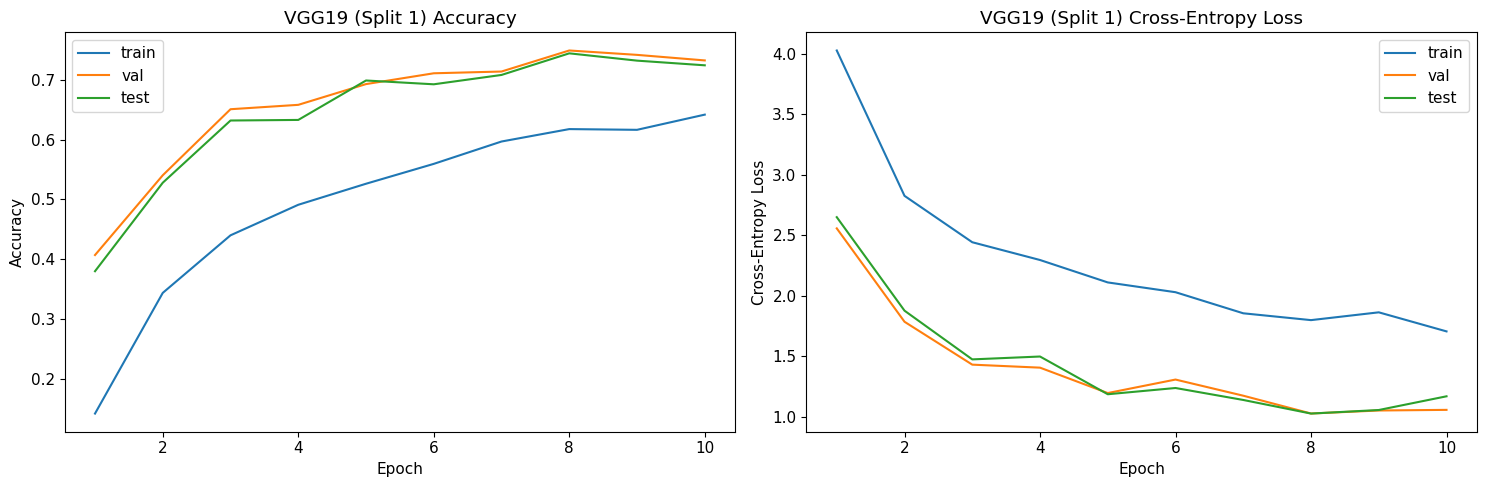

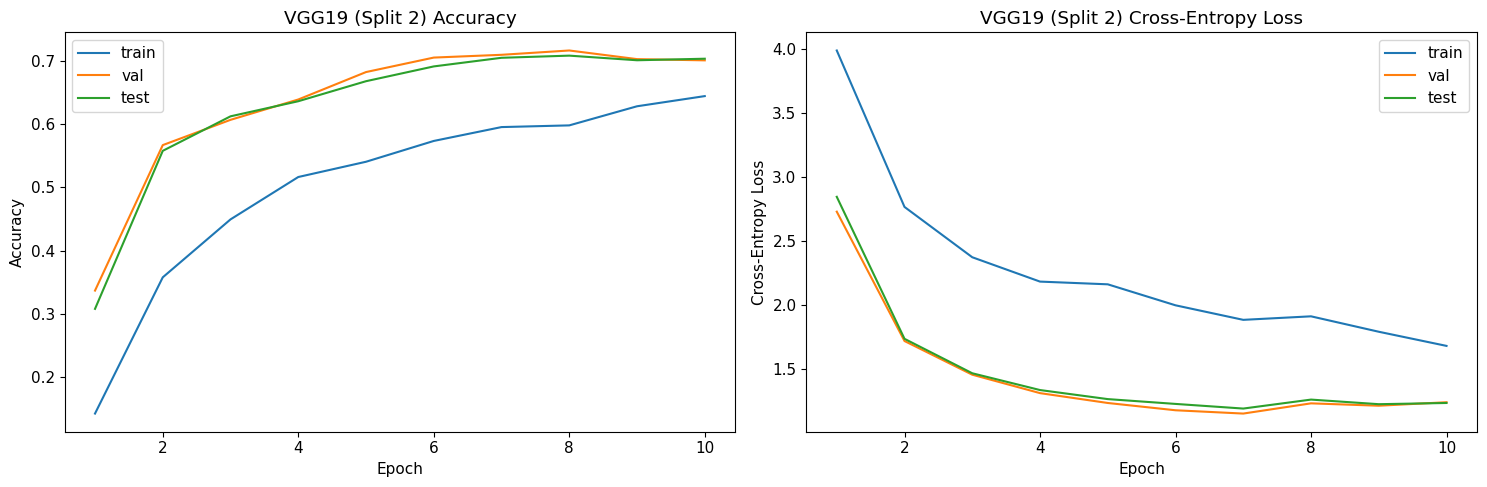

In [27]:
plot_history(HIST_VGG19_SPLIT1, title_prefix="VGG19 (Split 1)")
plot_history(HIST_VGG19_SPLIT2, title_prefix="VGG19 (Split 2)")

## YOLOv5 Curves

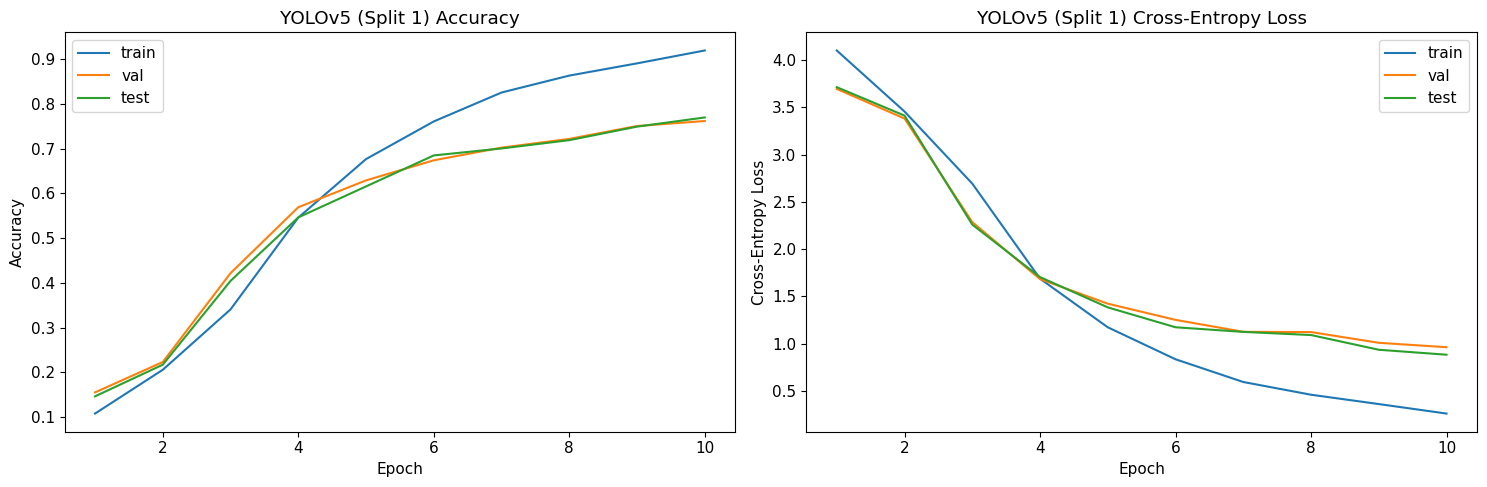

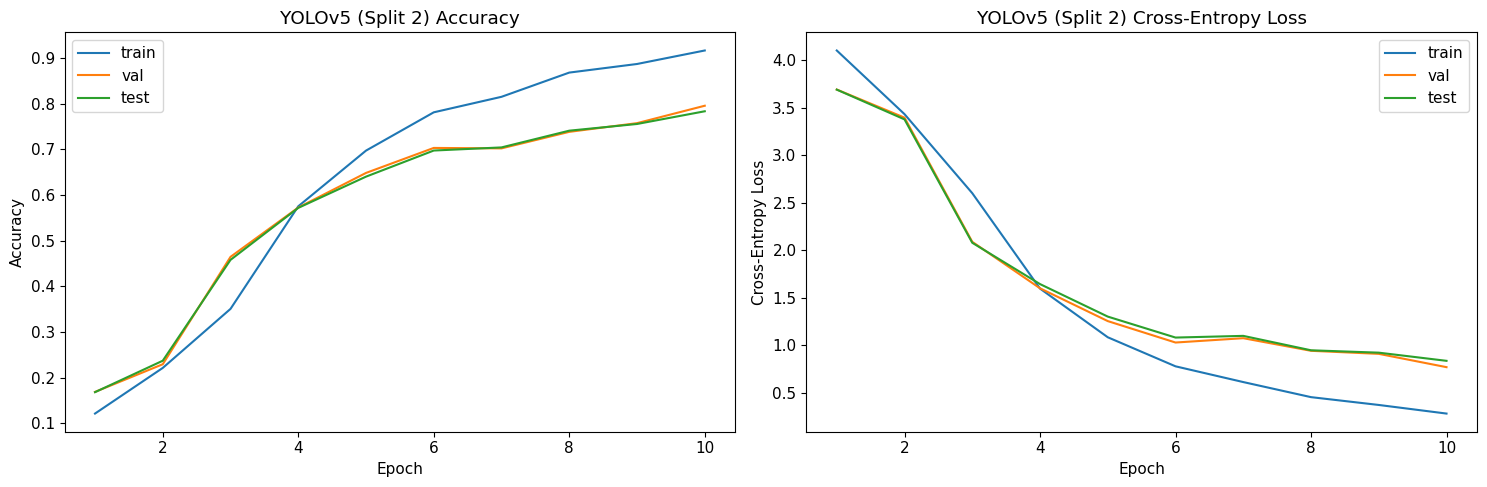

In [28]:
plot_history(HIST_YOLO_SPLIT1, title_prefix="YOLOv5 (Split 1)")
plot_history(HIST_YOLO_SPLIT2, title_prefix="YOLOv5 (Split 2)")

## Final Test Accuracy Summary

The table below summarizes the final epoch test accuracy for each model and each split.

In [29]:
summary_rows = [
    ["VGG19",  "Split 1", HIST_VGG19_SPLIT1["test_acc"][-1], HIST_VGG19_SPLIT1["test_loss"][-1]],
    ["VGG19",  "Split 2", HIST_VGG19_SPLIT2["test_acc"][-1], HIST_VGG19_SPLIT2["test_loss"][-1]],
    ["YOLOv5", "Split 1", HIST_YOLO_SPLIT1["test_acc"][-1],  HIST_YOLO_SPLIT1["test_loss"][-1]],
    ["YOLOv5", "Split 2", HIST_YOLO_SPLIT2["test_acc"][-1],  HIST_YOLO_SPLIT2["test_loss"][-1]],
]

df_summary = pd.DataFrame(summary_rows, columns=["Model", "Split", "Final Test Accuracy", "Final Test Loss"])
df_summary

,Model,Split,Final Test Accuracy,Final Test Loss
0,VGG19,Split 1,0.724121,1.167851
1,VGG19,Split 2,0.704102,1.236320
2,YOLOv5,Split 1,0.770020,0.882153
3,YOLOv5,Split 2,0.783203,0.838210


## Results Summary

The experimental results reveal clear differences between the two pretrained architectures in terms of convergence behavior, stability, and required training effort.

The **VGG19** model demonstrated consistent and stable learning across both random splits. After 10 epochs, it achieved test accuracies of approximately **72-74%** on Split 1 and **70-71%** on Split 2. Notably, VGG19 reached reasonable performance already in the early epochs, and the gap between training, validation, and test accuracy remained relatively small throughout training. This indicates good generalization and suggests that VGG19's ImageNet-pretrained features are well aligned with the flower classification task, requiring only a simple replacement of the final classification layer.

In contrast, the **YOLOv5-based classifier** exhibited a more complex training dynamic. When trained initially with a frozen backbone and a newly initialized classification head, the model achieved low accuracy levels (around **30-40%**) during the first training phase. Significant performance improvements were observed only after applying an extended fine-tuning stage, allowing the classifier to better adapt to the extracted features. Following this additional training effort, YOLOv5 reached higher final test accuracies of approximately **76-77%** on both splits, slightly outperforming VGG19.

Overall, while YOLOv5 ultimately achieved the highest test accuracy, it required **additional preprocessing, a multi-stage training strategy, and longer convergence time** to do so. VGG19, on the other hand, provided a more straightforward and robust transfer learning baseline, achieving strong and stable performance with considerably less tuning. These results highlight the trade-off between implementation simplicity and maximal accuracy when selecting a pretrained architecture for image classification tasks.